# Introduction

In this notebook we solve the computational exercises of the first problem set in macroeconomics 1, due by the 16th of November. This document is structured as follows: First, we implement functions necessary to compute the analytical solution, which boils down to two functions ``value_function_analytical`` and ``policy_function_analytical`` which map capital levels to the value und policy level, respectively, given the analytical solution. Second, we implement the functions necessary for the numerical implementation. The main function in this section is ``value_func_iteration`` and ``_internal_value_func_iteration`` which provide a wrapper and implementation of the value function iteration algorithm. At last we define a few helper functions to present the solutions to exercises in a nice fashion.

If you are only interested in the solutions please go directly to subsection "Exercise Solution".

### Preliminaries

You have to install numpy, pandas, seaborn, matplotlib and numba. (We use numba for speed but speed gains are limited since the exercise is so simple..)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
from numba import njit

sns.set_style("whitegrid")

## Analytical Solution

In [2]:
def alpha_one(alpha, beta):
    """Alpha one as computed in exercise 1.8
        
    Args:
        alpha (float): Capital exponent in production function
            F(k, l) = A * k ** alpha; 0 <= alpha.
        beta (float): Discount factor in household problem; 0 < beta < 1.
        
    Returns:
        out (float): Value of alpha_0.
        
    """
    return alpha / (1 - alpha * beta)

In [3]:
def alpha_zero(beta, technology, alpha_1):
    """Alpha zero as computed in exercise 1.8
    
    This computes alpha zero dependent on alpha_1. In principle alpha_0
    can be formulated without a dependence on alpha_1 but since I am bad
    in "algebra" I avoid taking the risk of making an error.
    
    Args:
        beta (float): Discount factor in household problem; 0 < beta < 1.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        alpha_one (float): The computed coefficient using function ``alpha_one``.
        
    Returns:
        out (float): Value of alpha_0.
    
    """
    alpha_one_beta = alpha_1 * beta
    out = alpha_one_beta * np.log(alpha_one_beta) + (1 + alpha_one_beta) * np.log(
        technology / (1 + alpha_one_beta)
    )
    out /= 1 - beta
    return out

In [4]:
def value_function_analytical(capital, alpha_0, alpha_1):
    """Analytical value function guess.
    
    Args:
        capital (float or np.ndarray): Capital.
        alpha_0 (float): Coefficient.
        alpha_1 (float): Coefficient.
        
    Returns:
        value (float or np.ndarray): Value given capital.
        
    """
    value = alpha_0 + alpha_1 * np.log(capital)
    return value

In [5]:
def policy_function_analytical(capital, alpha_1, alpha, beta, technology):
    """Analytical policy function guess.
    
    Args:
        capital (float or np.ndarray): Capital.
        alpha_1 (float): Coefficient.
        alpha (float): Capital exponent in production function
            F(k, l) = A * k ** alpha; 0 <= alpha.
        beta (float): Discount factor in household problem; 0 < beta < 1.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
            
    Returns:
        control (float or np.ndarray): Control policy.
        
    """
    control = alpha_1 * beta * technology * (capital ** alpha)
    control /= 1 + alpha_1 * beta
    return control

## Numerical Solution

#### Auxiliary Functions:

In [6]:
@njit
def production_func(capital, technology, alpha):
    """Production function.
    
    F(k, l) = A * k ** alpha, where k denotes capital.
    
    Args:
        capital (float or np.ndarray): Capital.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        alpha (float): Capital exponent in production function.
            F(k, l) = A * k ** alpha; 0 <= alpha.
    
    Returns:
        production (float or np.ndarray): Production level.
        
    """
    production = technology * capital ** alpha
    return production

In [7]:
@njit
def utility_func(capital_today, capital_tomorrow, alpha, technology):
    """Utility function only dependent on capital.
    
    Utility function is given as U(c) where c is the level of consumption. The level
    of consumption can be substituted by c = log(f(k) - k'), where f denotes the
    production function, k the level of capital today and k' the level of capital
    tomorrow.
    
    Args:
        capital_today (float or np.ndarray): Capital levels today.
        capital_tomorrow (float or np.ndarray): Capital levels tomorrow.
        alpha (float): Capital exponent in production function.
            F(k, l) = A * k ** alpha; 0 <= alpha.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        
    Returns:
        utility (float or np.ndarray): Utility level given "consumption". 
    
    """
    utility = np.log(
        production_func(capital_today, technology, alpha) - capital_tomorrow
    )
    return utility

In [8]:
@njit
def sup_norm_metric(arr1, arr2):
    """Supremum norm metric defined on arrays.
    
    Computes, with n := length(arr1),
    
        max_{i=1,...,n} |arr1_i - arr2_i|
    
    Args:
        arr1 (np.ndarray): Array of length n.
        arr2 (np.ndarray): Array of length n.
        
    Returns:
        distance (float): Supremum norm.
        
    """
    distance = np.max(np.abs(arr1 - arr2))
    return distance

In [9]:
@njit
def resize(array2d, new_size):
    """Resize two dimensional array.
    
    Args:
        array2d (np.ndarray): Two dim numpy array.
        new_size (tuple): New dimensions.
        
    Returns:
        new (np.ndarray): Array with new dimensions where new
            entries are filled with zeroes.
            
    """
    new = np.zeros(new_size, array2d.dtype)
    n, m = array2d.shape
    new[:n, :m] = array2d
    return new

In [10]:
@njit
def double_array_size(array):
    """Double array size.
    
    Args:
        array (np.ndarray): Two dim. numpy array of shape (n, m).
    
    Returns:
        array (np.ndarray): Two dim. numpy array of shape (2*n, m) with the last n rows
            filled with zeros.
    
    """
    array = array.copy()
    nrows, ncols = array.shape
    array = resize(array, (2 * nrows, ncols))
    return array

#### Algorithm (Value Function Iteration):

In [11]:
@njit
def _internal_value_func_iteration(
    alpha, beta, technology, capital_grid, tolerance, initial_array_size,
):
    """Internal value function iterations.
    
    The algorithm implemenation works as follows. We fill an array with
    columns corresponding to values in the capital grid and rows
    corresponding to iterations. The first guess fills the first row.
    From here on we iteratively fill each row by solving the Bellman
    equation. Since the previous row of the array gives the values of
    the Value function of the previous iteration this amounts to solving
    a simple maximum problem over a finite array. In each iteration the
    supremum distance is then computed on consecutive rows. As soon as
    this distance falls below the given tolerance the algorithm terminates.
    
    Args:
        alpha (float): Capital exponent in production function.
            F(k, l) = A * k ** alpha; 0 <= alpha.
        beta (float): Discount factor in household problem; 0 < beta < 1.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        capital_grid (np.ndarray or list-like): List of discretized capital
            values of which we optimize.
        tolerance (float): Positive float indicating the tolerance for the
            numerical approximation.
        return_info (bool): Should extra information be returned? Defaults to
            True.
        initial_array_size (int): Initial size of array which is filled during
            the iteration process.
    
    """
    distance = np.inf

    value_array = np.zeros((initial_array_size, len(capital_grid)))
    policy_array = np.empty(len(capital_grid))

    n = 1
    while distance > tolerance:

        # initial array size is preallocated and must be increased if necessary
        if n == initial_array_size:
            value_array = double_array_size(value_array)
            initial_array_size *= 2

        # algorithm:
        for j, capital in enumerate(capital_grid):
            old_values = value_array[n - 1, :]
            to_max = (
                utility_func(capital, capital_grid, alpha, technology)
                + beta * old_values
            )
            argmax = np.argmax(to_max)
            value_array[n, j] = to_max[argmax]
            policy_array[j] = capital_grid[argmax]

        distance = sup_norm_metric(value_array[n - 1, :], value_array[n, :])
        n += 1

    return value_array, policy_array, n

In [12]:
def value_func_iteration(
    alpha,
    beta,
    technology,
    capital_grid,
    tolerance=10e-6,
    return_info=False,
    initial_array_size=1_000,
):
    """Value function iteration.
    
    For an explaination see the corresponding interal function.
    
    Args:
        alpha (float): Capital exponent in production function.
            F(k, l) = A * k ** alpha; 0 <= alpha.
        beta (float): Discount factor in household problem; 0 < beta < 1.
        technology (float): Technology parameter of production function (A) in 
            F(k, l) = A * k ** alpha; 0 <= A.
        capital_grid (np.ndarray or list-like): List of discretized capital
            values of which we optimize.
        tolerance (float): Positive float indicating the tolerance for the
            numerical approximation. Defaults to 10e-6.
        return_info (bool): Should extra information be returned? Defaults to
            True.
        initial_array_size (int): Initial size of array which is filled during
            the iteration process. Defaults to 1_000.

    
    Returns:
        result (pd.DataFrame): Frame containing values given capital grid.
        info (dict): Extra information on the optimization; only returned if
            return_info is True.
    
    """
    capital_grid = np.array(capital_grid)

    value_array, policy_array, n = _internal_value_func_iteration(
        alpha, beta, technology, capital_grid, tolerance, initial_array_size
    )

    info = {
        "number_of_iterations": n - 1,
        "value_array": value_array[:n, :],
    }

    result = np.c_[capital_grid, value_array[n - 1, :], policy_array]
    result = pd.DataFrame(result, columns=["capital", "values", "policy"])

    out = (result, info) if return_info else result
    return out

## Computation

#### Auxiliary function for exercise presenation

In [13]:
def exercise_solution(
    capital_grid, alpha=0.3, beta=0.6, technology=20, return_df=False
):
    """Solution to exercises 1.9-1.12.
    
    Plot value and policy function on capital grid with numerical and
    analytical solution.
    
    Args:
        return_df (bool): If True data frame with results is returned.
            Defaults to false.
    
    Returns:
        df (pd.DataFrame): Results data frame in tidy format.
    
    """
    # analytical solution
    alpha_1 = alpha_one(alpha, beta)
    alpha_0 = alpha_zero(beta, technology, alpha_1)

    capital_grid_fine = np.linspace(2, 10, num=1000)
    analytical = {
        "values": value_function_analytical(capital_grid_fine, alpha_0, alpha_1),
        "policy": policy_function_analytical(
            capital_grid_fine, alpha_1, alpha, beta, technology
        ),
    }

    # numerical solution
    df = value_func_iteration(alpha, beta, technology, capital_grid)

    # create plot
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18, 8)

    for i, func_type in enumerate(["values", "policy"]):
        # seaborn plots
        ana = sns.lineplot(
            x=capital_grid_fine,
            y=analytical[func_type],
            ax=ax[i],
            linewidth=2,
            label="analytical",
        )
        num = sns.lineplot(
            x=df["capital"], y=df[func_type], ax=ax[i], linewidth=2, alpha=0.7, label="numerical"
        )
        # customize axis
        ax[i].set_frame_on(False)
        ax[i].set_title(f"{func_type} function".capitalize(), fontsize=16, pad=-15)
        ax[i].legend(
            loc="lower right", frameon=False, bbox_to_anchor=(0.96, 0.14), fontsize=14
        )
        ax[i].xaxis.label.set_size(12)
        ax[i].yaxis.label.set_size(12)

    plt.show()

    # return results (for debugging)
    out = df if return_df else None
    return out

## Exercise Solutions:

#### Exercise 1.9 and 1.10

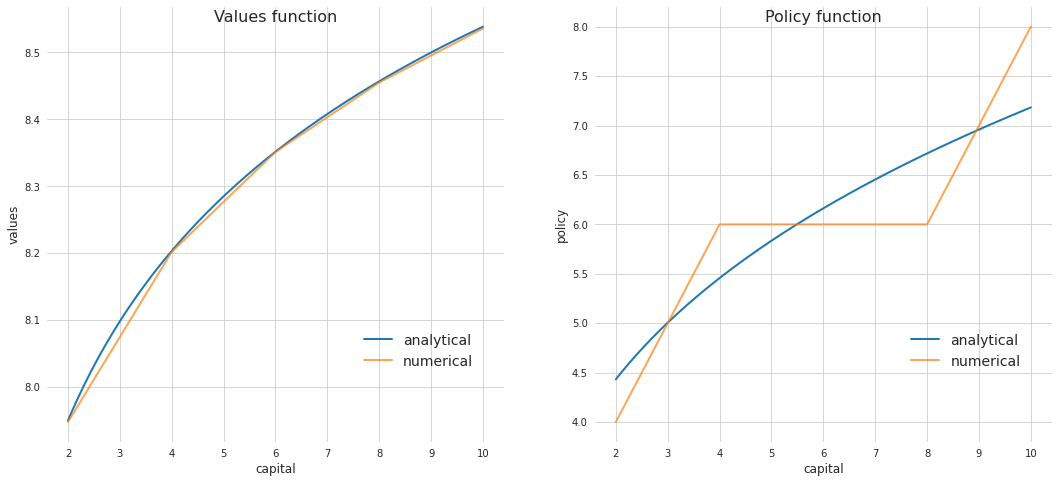

In [14]:
exercise_solution(capital_grid=np.arange(2, 12, 2))

#### Exericse 1.11 and 1.12

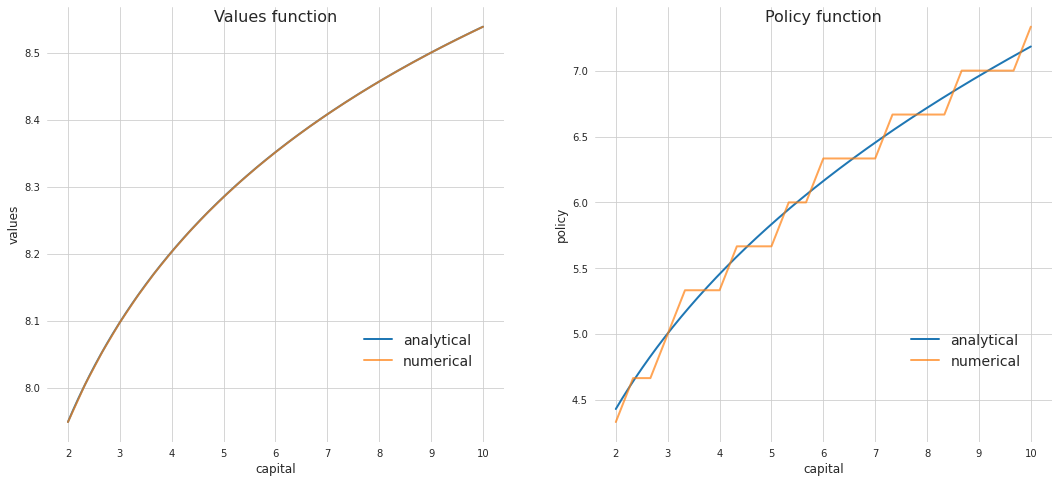

In [15]:
# capital grid 2 to 10 with 50 steps
exercise_solution(capital_grid=np.linspace(2, 10, num=25))

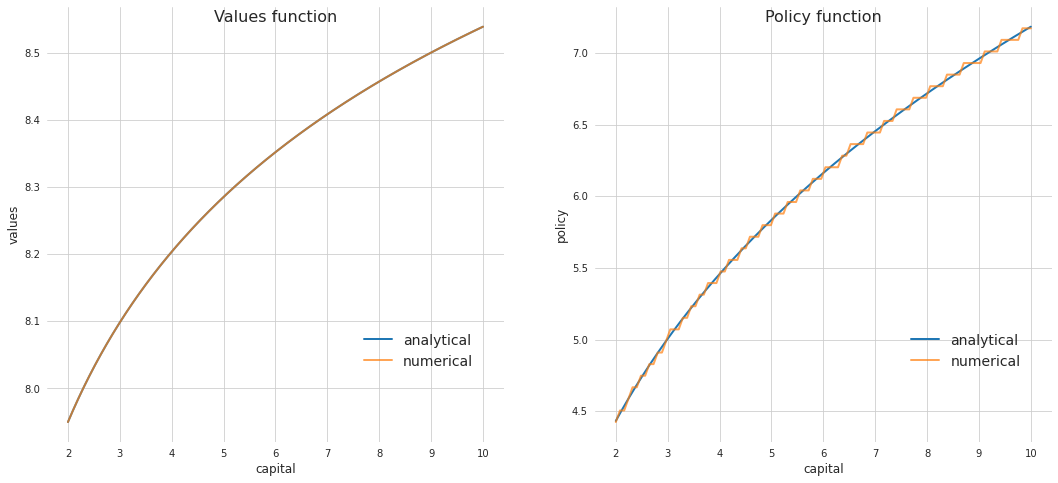

In [16]:
# capital grid 2 to 10 with 100 steps
exercise_solution(capital_grid=np.linspace(2, 10, num=100))

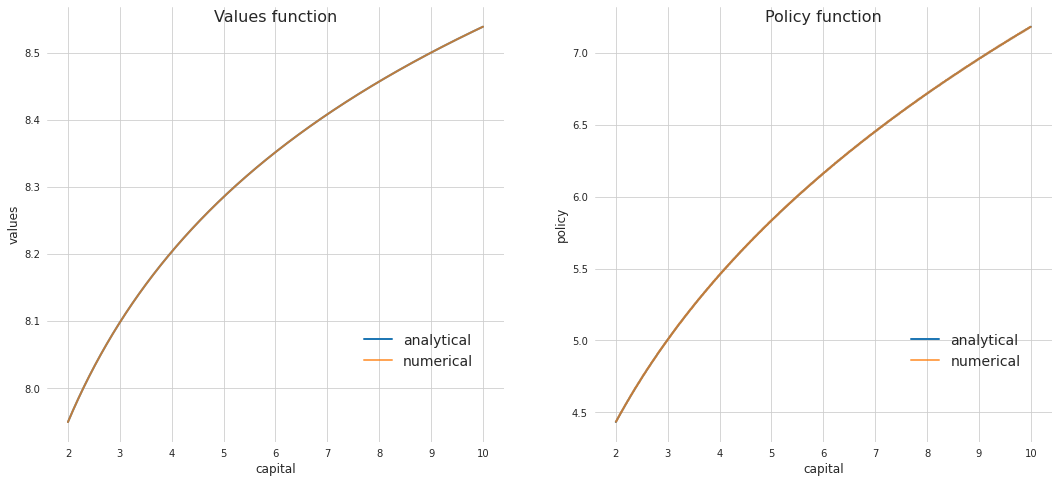

In [17]:
# capital grid 2 to 10 with 1000 steps
exercise_solution(capital_grid=np.linspace(2, 10, num=1_000))

#### Exercise 1.13

In [18]:
alpha_1 = alpha_one(alpha=0.3, beta=0.6)
policy_func = partial(policy_function_analytical, alpha_1=alpha_1, alpha=0.3, beta=0.6, technology=20)

In [19]:
capital_path = np.zeros(21)
capital_path[0] = 2

for i in range(20):
    capital_path[i+1] = policy_func(capital_path[i])

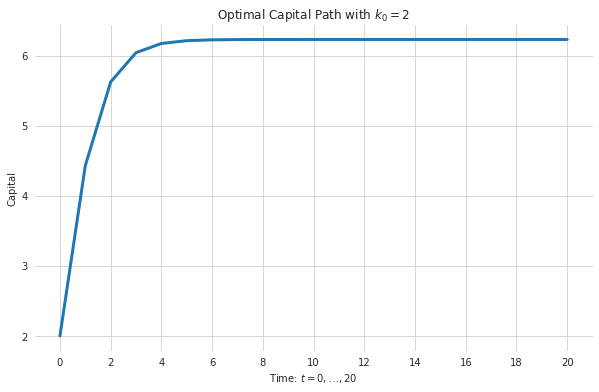

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(capital_path)), y=capital_path, linewidth=3)
plt.title("Optimal Capital Path with $k_0 = 2$")
plt.xlabel("Time: $t=0,\dots,20$")
plt.ylabel("Capital")
plt.xticks(np.arange(0, len(capital_path), 2))
plt.box(False)
plt.show()